## Test mpdata
 
 Prendre comme score uniquement le recall est un mauvais calcul, car si on prédit que tous les joueurs sont de la classe 1, alors on a un score de 1. Évidemment on aura énormément de faux positifs et donc de l'investissement perdu dans tous ces joueurs qui n'ont pas passé le cap des 5 ans... On va donc inclure le fait qu'on ne veut pas parier sur des joueurs qui sont de la classe 0. 
 Il faut d'une part que la plupart des classe 1 soient détectés (maximisation du recall) et d'autre part que, par rapport au nombre de classe 1, peu de classe 0 soient considérées comme classe 1 (maximisation de la précision). Sans plus d'information sur les préférences des investisseurs, on choisit simplement le F-score qui est la moyenne harmonique entre ces deux grandeurs.

In [1]:
%cd '/Users/cdutertre/Documents/info/mpdata/Test Data Science'

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
import copy

def score_classifier(dataset,classifier,labels):

    """
    performs 3 random trainings/tests to build a confusion matrix and prints results with precision and recall scores
    :param dataset: the dataset to work on
    :param classifier: the classifier to use
    :param labels: the labels used for training and validation
    :return: the fscore and prediction function of the fitted classifier averaged on the 3 folds
    """

    kf = KFold(n_splits=3,random_state=50,shuffle=True)
    confusion_mat = np.zeros((2,2))
    recall = 0
    fscore = 0
    clf_list = []
    for training_ids,test_ids in kf.split(dataset):
        training_set = dataset[training_ids]
        training_labels = labels[training_ids]
        test_set = dataset[test_ids]
        test_labels = labels[test_ids]
        classifier.fit(training_set,training_labels)
        clf_list.append(copy.deepcopy(classifier))
        predicted_labels = classifier.predict(test_set)
        confusion_mat+=confusion_matrix(test_labels,predicted_labels)
        recall += recall_score(test_labels, predicted_labels) 
        fscore += f1_score(test_labels, predicted_labels) 
    recall/=3
    fscore/=3
    #print(confusion_mat)
    #print(fscore)
    
    # return the score and also the fitted classifier averaged on the folds
    return fscore, lambda x: (np.mean([clf.predict(x) for clf in clf_list], axis=0) > .5).astype(int)

/Users/cdutertre/Documents/info/mpdata/Test Data Science


In [22]:
# Load dataset
df = pd.read_csv("nba_logreg.csv")

# extract names, labels, features names and values
names = df['Name'].values.tolist() # players names
labels = df['TARGET_5Yrs'].values # labels
paramset = df.drop(['TARGET_5Yrs','Name'],axis=1).columns.values
df_vals = df.drop(['TARGET_5Yrs','Name'],axis=1).values

# replacing Nan values (only present when no 3 points attempts have been performed by a player)
for x in np.argwhere(np.isnan(df_vals)):
    df_vals[x]=0.0

# normalize dataset : set all values between 0 and 1
mmscaler = MinMaxScaler()
X = mmscaler.fit_transform(df_vals)

pd.DataFrame(X,columns=paramset).head()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,0.439024,0.669927,0.262411,0.254902,0.383838,0.470828,0.217391,0.323077,0.250,0.207792,0.225490,0.699,0.132075,0.354167,0.294964,0.179245,0.16,0.102564,0.295455
1,0.426829,0.657702,0.255319,0.196078,0.338384,0.401628,0.304348,0.430769,0.235,0.337662,0.333333,0.765,0.094340,0.208333,0.172662,0.349057,0.44,0.128205,0.363636
2,0.902439,0.374083,0.184397,0.196078,0.237374,0.572592,0.173913,0.261538,0.244,0.116883,0.127451,0.670,0.094340,0.177083,0.158273,0.094340,0.20,0.076923,0.227273
3,0.707317,0.283619,0.202128,0.225490,0.277778,0.578019,0.043478,0.076923,0.226,0.116883,0.127451,0.689,0.188679,0.093750,0.136691,0.075472,0.24,0.025641,0.227273
4,0.585366,0.281174,0.159574,0.156863,0.151515,0.710991,0.000000,0.015385,0.000,0.168831,0.186275,0.674,0.188679,0.156250,0.179856,0.028302,0.12,0.102564,0.181818


In [3]:
# Number and proportion of 1's
ones = sum(labels)
total = len(labels)
print(ones,total,ones/total*100)
# The dataset is rather balanced

831.0 1340 62.01492537313433


In [4]:
#example of scoring with support vector classifier
r,clf = score_classifier(X,SVC(gamma='auto'),labels)
print(r)

0.7809607039936172


Avant de commencer, je propose de réaliser une analyse exploratoire rapide (via une acp). On pourrait notamment y détecter des outliers le cas échéant, et voir si certaines features sont beaucoup moins importantes que d'autres.

Text(0, 0.5, 'PC2')

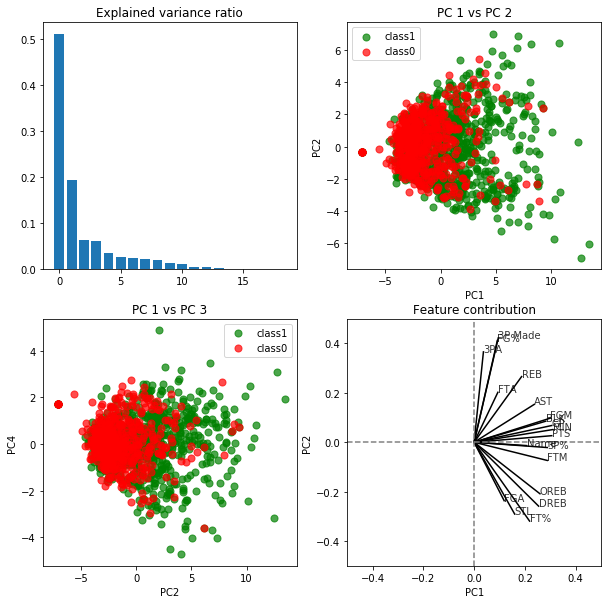

In [5]:
# Standardize data to perform PCA
stdscaler = StandardScaler()
Xstd = stdscaler.fit_transform(X)
pca = PCA()
pcanalysis = pca.fit(Xstd)
Xpcs = pca.transform(Xstd)

targets = [1,0]
colors = ['g', 'r']

Xdf_pca = pd.DataFrame(data = Xpcs[:,0:3],columns = ['PC1','PC2','PC3'])
df_pca = pd.concat([Xdf_pca,df[['TARGET_5Yrs']]], axis=1)

fig = plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.bar(np.arange(19),pcanalysis.explained_variance_ratio_,)
plt.title("Explained variance ratio")

ax = fig.add_subplot(2,2,2)
ax.set_title("PC 1 vs PC 2")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
for target, color in zip(targets,colors):
    indicesToKeep = df['TARGET_5Yrs'] == target
    ax.scatter(df_pca.loc[indicesToKeep, 'PC1'],df_pca.loc[indicesToKeep, 'PC2'], c=color, s=50, alpha = 0.7)
ax.legend(["class1","class0"])

ax = fig.add_subplot(2,2,3)
ax.set_title("PC 1 vs PC 3")
ax.set_xlabel("PC2")
ax.set_ylabel("PC4")
for target, color in zip(targets,colors):
    indicesToKeep = df['TARGET_5Yrs'] == target
    ax.scatter(df_pca.loc[indicesToKeep, 'PC1'],df_pca.loc[indicesToKeep, 'PC3'], c=color, s=50, alpha = 0.7)
ax.legend(["class1","class0"])

ax = fig.add_subplot(2,2,4)
pcs = pcanalysis.components_

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    ax.plot([0, x], [0, y], color='k')
    ax.text(x, y, df.columns[i], fontsize='10',alpha=0.8)

ax.plot([-0.5, 0.5], [0, 0], color='grey', ls='--')
ax.plot([0, 0], [-0.5, 0.5], color='grey', ls='--')
ax.set_xlim([-0.5, 0.5])
ax.set_ylim([-0.5, 0.5])
ax.set_title('Feature contribution')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

On constate que le jeu de données est à peu près propre, en tout cas il n'y a pas de gros outlier. Avec cette simple analyse linéaire, on voit déjà que la composante expliquant le plus de variance est celle qui détermine la performance (toutes les variables lui sont positivement corrélées : elles semblent donc toutes mesurer toutes une performance "positive"). Et on voit que les points intéressants se séparent suivant cette composante.
Si on en reste à ce modèle linéaire, il faudrait garder environ les 4 premières composantes, et dans celles-ci (la 4e n'est pas plottée), seule la première discrimne les joueurs intéressants. Ceci rendrait le problème unidimensionnel, et on se doute que l'on ne pourra pas obtenir des résultats optimaux comme ca. (Ceci dit, on peut remarquer que l'acp nous permet d'isoler certaines caractéristiques des joueurs : la PC2 a l'air de discriminer les shooters à 3 points des dribblers, mais ce n'est pas le sujet).

On va donc plutôt appliquer quelques modèles classiques : SVC, régression logistique, K-NN, randomForest, et gradient Boosting. 
Pour cela nous allons déjà séparer notre dataset en train/test. Ensuite on optimisera leurs hyperparamètres sur le training set puis on pourra comparer leurs performances avec le test.
On pourra alors éventuellement combiner ces modèles. Pour finir on entraînera le modèle final sur l'ensemble des données.

Pour l'optimisation, on pourrait utiliser une GridSearchCV, mais vu qu'on a une fonction scoring qui fait déjà une cv, on va le faire simplement à la main.

In [6]:
#set a random_state
rs=50

# split the dataset
X_train,X_test,y_train,y_test = train_test_split(X,labels,test_size=0.3,random_state=rs,shuffle=True,stratify=labels)

clf_list = [] # will store the chosen (unfitted but optimized) classifiers
pred_list = [] # will store the chosen (trained on X_train) prediction functions returned by score_classifier

In [11]:
# We test for l2 penalization, and C between 0.01 and 100

Cs = np.logspace(-2,2,num = 10)
C_best,score_best = 0,0
logReg_pred = None # Will store the optimized model
logReg_best = None # Will store the fitted optimized classifier

for c in Cs:
    logReg = LogisticRegression(solver = 'lbfgs',C=c,random_state=rs,max_iter=1000)
    f,pred = score_classifier(X_train,logReg,y_train)
    if f>score_best:
        C_best,score_best = c,f
        logReg_best = logReg
        logReg_pred = pred

clf_list.append(logReg_best)
pred_list.append(logReg_pred)
res = dict({'logReg' : score_best}) # will store training results of the differents models

In [12]:
# Now the KNN model : we test between 3 and 30 neighbors
neighs = np.arange(3,30,2)
k_best,score_best = 0,0
kNN_pred = None
kNN_best = None

for k in neighs:
    kNN = KNeighborsClassifier(n_neighbors = k)
    f,pred = score_classifier(X_train,kNN,y_train)
    if f>score_best:
        k_best,score_best = k,f
        kNN_pred = pred
        kNN_best = kNN

clf_list.append(kNN_best)
pred_list.append(kNN_pred)
res['kNN'] = score_best

In [13]:
# Now the SVC, we'll use the rbf kernel and tune gamma and C looking between 0.01 and 100 for both
gammas = np.logspace(-2,2,10)
Cs = np.logspace(-2,2,10)

gamma_best,C_best,score_best = 0,0,0
SVC_pred = None
SVC_best = None

for gamma in gammas:
    for C in Cs:
        svc = SVC(C=C,gamma=gamma,random_state=rs)
        f,pred = score_classifier(X_train,svc,y_train)
        # remember only the best model (/ parameters)
        if(f > score_best):
            gamma_best,C_best,score_best = gamma,C,f
            SVC_pred = pred
            SVC_best = svc

clf_list.append(SVC_best)
pred_list.append(SVC_pred)
res['SVC'] = score_best

In [14]:
# Now the random forest
# We'll optimize over the number of estimators and max_depth, leaving other parameters as default
n_ests = np.arange(50,501,100)
max_depths = [2,5,10,None]

nest_best,mdepth_best,score_best = 0,0,0
rf_pred = None
rf_best = None

for n_est in n_ests:
    for i,max_depth in enumerate(max_depths):
        rf = RandomForestClassifier(n_estimators=n_est, max_depth=max_depth, random_state=rs)
        f,pred = score_classifier(X_train,rf,y_train)
        if f>score_best:
            nest_best,mdepth_best,score_best = n_est,max_depth,f 
            rf_pred = pred
            rf_best = rf

clf_list.append(rf_best)
pred_list.append(rf_pred)
res['Random Forest'] = score_best
print(nest_best,mdepth_best)    

450 2


Pour les random forest, nous aurions surement bénéficié d'une gridsearchcv pour faire l'optimisation des hyperparamètres plus simplement. Ici par soucis de cohérence j'ai gardé la même méthode, mais avec plus de temps j'aurais réécrit tout avec des gridsearchCV (on aurait pu aussi facilement pu regarder plus d'hyperparamètres que seulement n_est et max_depth).

D'autre part on voit que le nombre d'arbres choisis est presque le max, ce qui n'est pas étonnant, mais certainement pas optimal. Vu la taille du dataset ce n'est pas très grave. On aurait pu cependant plot les learning curves pour optimiser.
De même pour le gradient boosting qui suit, plot les learning curve serait aussi informatif. Je ne le fais pas par manque de temps mais ce serait préférable à mon avis (même si je vais quand même m'assurer sur le test set qu'on garde un bon pouvoir prédictif).

In [15]:
# Last, the Gradient Boosting. We'll optimize over n_estimators and max_features
n_ests = np.arange(50,501,100)
max_feats = [2,4,6,10,None]

nest_best,mfeat_best,score_best = 0,0,0
gb_pred = None
gb_best = None

for n_est in n_ests:
    for i,max_feat in enumerate(max_feats):
        gb = GradientBoostingClassifier(n_estimators=n_est,max_features=max_feat,random_state=rs)
        f,pred = score_classifier(X_train,gb,y_train)
        if(f > score_best):
            nest_best,mfeat_best,score_best = n_est,max_feat,f 
            gb_pred = pred
            gb_best = gb
            
clf_list.append(gb_best)
pred_list.append(gb_pred)
res['Gradient Boosting'] = score_best
print(nest_best,mfeat_best)  

150 None


In [16]:
res

{'logReg': 0.7667253998373544,
 'kNN': 0.74478662453346,
 'SVC': 0.7700998851031038,
 'Random Forest': 0.7611652307406781,
 'Gradient Boosting': 0.751542066101803}

Maintenant qu'on a optimisé nos différents modèles, on va comparer leur efficacité sur le test set et afficher tout cela dans une heatmap

0.7999999999999999
0.7715930902111324
0.7911275415896488
0.7886792452830188
0.7547892720306514


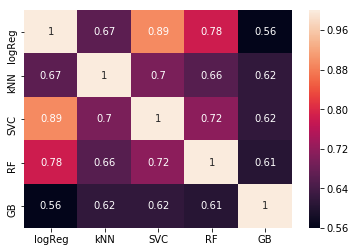

In [17]:
clf_names = ['logReg','kNN','SVC','RF','GB']
prediction_list = [pd.Series(pred(X_test)) for pred in pred_list]
res_df = pd.concat(prediction_list,axis=1)

# print the different scores on the test set
#for res in res_list:
#    print(f1_score(y_test,res))

for res in prediction_list:
    print(f1_score(y_test,res))
    
#plot the heatmap using sns
g= sns.heatmap(res_df.corr(),xticklabels = clf_names,yticklabels = clf_names,annot=True)

On peut voir que les modèles sont assez peu corrélés, ce qui nous pousse à les agréger pour faire le modèle final. Pour cela on pourrait par exemple utiliser un VotingClassifier, mais vu que nos classifieurs ont renvoyé directement la classe et pas une probabilité, cela revient à faire un simple vote à la majorité.
Notre modèle final sera donc le vote à la majorité des 5 modèles que nous avons définis. Pour terminer on va ré-entraîner une dernière fois ces modèles sur l'ensemble du dataset et on pourra coder notre modèle agrégé final.

In [19]:
final_pred_list = []
for clf in clf_list:
    #fit the classifiers on all the data
    f,pred = score_classifier(X,clf,labels)
    final_pred_list.append(pred)

In [20]:
# final prediction : majority voting. 
# For 5 elements it is equivalent to integer-dividing by 3
final_pred = lambda x: sum([pred(x) for pred in final_pred_list])//3

Voilà pour la première partie. La seconde partie se trouve dans le fichier test.py initial.
Pour être honnête, je ne m'y connais pas du tout en web. J'ai passé pas mal de temps, mais pour bien comprendre tout ça, quelques heures ne suffisent pas. Donc j'ai repris une implémentation en flask que j'ai trouvée en ligne et que j'ai adaptée. Je pense que cette partie est bien améliorable, par exemple on aurait pu essayer d'éliminer des features peu informatives pour rendre l'utilisation du webservice plus agréable, ou encore accepter des données manquantes (en complétant dans le code par la médiane typiquement).